In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# !ls "/content/drive/MyDrive"

# import os

# %cd "/content"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Colab Notebooks'			     fox
 dataset				     pothole_resnet_50_model.h5
 datasets				     pothole_vgg_model.h5
 diabetic_retinopathy_resnet_50_model.h5     yolov3
 diabetic_retinopathy_resnet_50v2_model.h5   yolov5
/content


In [2]:
# !ls "/content/drive/MyDrive/datasets"

'Blood Cell Dataset.zip'   coco128		   detection_data
'brain segmentation.zip'   coco2017labels.zip	   Diabetic_Dataset.zip
 braintumor_dataset.zip    Dataset_FireSmoke.zip   livertumordataset1.zip
 coco			   dataset.zip


In [3]:
# base_dataset_folder = "/content/drive/MyDrive/datasets/"
# zip_file = "Diabetic_Dataset.zip"
# dataset_zip = base_dataset_folder+zip_file

In [4]:
# !mkdir dataset
# !unzip $dataset_zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/Diabetic_Dataset/4/007-6553-400.jpg  
  inflating: dataset/Diabetic_Dataset/4/007-6482-400.jpg  
  inflating: dataset/Diabetic_Dataset/4/007-7188-400.jpg  
  inflating: dataset/Diabetic_Dataset/4/007-6492-400.jpg  
  inflating: dataset/Diabetic_Dataset/4/007-7198-400.jpg  
  inflating: dataset/Diabetic_Dataset/4/007-6828-400.jpg  
  inflating: dataset/Diabetic_Dataset/4/007-6950-400.jpg  
  inflating: dataset/Diabetic_Dataset/4/007-6838-400.jpg  
  inflating: dataset/Diabetic_Dataset/4/007-6940-400.jpg  
  inflating: dataset/Diabetic_Dataset/4/007-6932-400.jpg  
  inflating: dataset/Diabetic_Dataset/4/007-6922-400.jpg  
  inflating: dataset/Diabetic_Dataset/4/007-6786-400.jpg  
  inflating: dataset/Diabetic_Dataset/4/007-6796-400.jpg  
  inflating: dataset/Diabetic_Dataset/4/007-6598-400.jpg  
  inflating: dataset/Diabetic_Dataset/4/007-6588-400.jpg  
  inflating: dataset/Diabetic_Dataset/4/007-6019-300.jpg  
  inf

## Diabetic Retinopathy Disease Classification

### 1) Import Needed Modules

In [6]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow import keras
from numba import cuda

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import gc

print("Loading Libraries Done")

Loading Libraries Done


In [7]:
data = pd.read_csv("DR_grading.csv")
data

,id_code,diagnosis
0,20170413102628830.jpg,0
1,20170413111955404.jpg,0
2,20170413112015395.jpg,0
3,20170413112017305.jpg,0
4,20170413112528859.jpg,0
...,...,...
12517,007-6761-400.jpg,4
12518,007-6762-400.jpg,4
12519,007-6763-400.jpg,4
12520,007-6764-400.jpg,4


In [15]:
#DR severity: none, mild, moderate, severe, and proliferative DR.

dataset_folder = "Diabetic_Dataset"
#os.mkdir(dataset_folder)

try:
    os.mkdir(dataset_folder)
except:
    pass # Folder already available

try:
    os.mkdir(dataset_folder+"/0")
except:
    pass # Folder already available


try:
    os.mkdir(dataset_folder+"/1")
except:
    pass # Folder already available

try:
    os.mkdir(dataset_folder+"/2")
except:
    pass # Folder already available

try:
    os.mkdir(dataset_folder+"/3")
except:
    pass # Folder already available

try:
    os.mkdir(dataset_folder+"/4")
except:
    pass # Folder already available


### 2) Data loading

In [16]:

main_folder = "./Diabetic_Dataset"
RANDOM_SEED = 6

categories = os.listdir(main_folder)
try:
    categories.remove(".DS_Store")
except:
    pass
print(categories, len(categories))



['0', '1', '2', '3', '4'] 5


In [23]:
import shutil
base_path = "./DR_grading/"
for row in data.values:
    img_name = str(row[0])
    img_class = str(row[1])
    img_path = base_path + img_name #Current Image Path
    final_path = dataset_folder + "/" + img_class+ "/"+ img_name #Folder to which Image should be Copied
    print(img_name, img_class, img_path)
    shutil.copyfile(img_path, final_path) # Copy the Image to suitable Class folder
    print("Moved Image: ", img_path , "---->", final_path)
    
    

20170413102628830.jpg 0 ./DR_grading/20170413102628830.jpg


FileNotFoundError: [Errno 2] No such file or directory: './DR_grading/20170413102628830.jpg'

In [4]:
TOTAL_CATEGORIES = len(categories)
IMAGE_SIZE = (224,224,3)

def load_images_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        print(index, category)
        for image_name in tqdm(os.listdir(main_folder+"/"+category)):
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg"):
              try:
                    imgname = main_folder+"/"+category+"/"+image_name
                    imgname = imgname.replace("//", "/")
                    img = cv2.imread(imgname)
                    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    # img_rotated_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                    # img_rotated_180 = cv2.rotate(img, cv2.ROTATE_180)
                    # img_rotated_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                    # img_flip_ver = cv2.flip(img, 0)
                    # img_flip_hor = cv2.flip(img, 1)

                    # img_array = Image.fromarray(img, 'RGB')
                    # img_lst.append(np.array(img_array))
                    # labels.append(index)

                    # img_array = Image.fromarray(img_rotated_90, 'RGB')
                    # img_lst.append(np.array(img_array))
                    # labels.append(index)

                    # img_array = Image.fromarray(img_rotated_180, 'RGB')
                    # img_lst.append(np.array(img_array))
                    # labels.append(index)

                    # img_array = Image.fromarray(img_rotated_270, 'RGB')
                    # img_lst.append(np.array(img_array))
                    # labels.append(index)

                    # img_array = Image.fromarray(img_flip_ver, 'RGB')
                    # img_lst.append(np.array(img_array))
                    # labels.append(index)

                    # img_array = Image.fromarray(img_flip_hor, 'RGB')
                    # img_lst.append(np.array(img_array))
                    # labels.append(index)

              except:
                    print(imgname)
                    print(img)
                

    return img_lst, labels

images, labels = load_images_labels(categories)
print()
print("Total Images Loaded:", len(images))

0 0


100%|██████████| 6266/6266 [02:39<00:00, 39.36it/s] 


1 1


 59%|█████▉    | 371/630 [00:13<00:11, 22.80it/s]

./Diabetic_Dataset/1/007-2636-100.jpg
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


100%|██████████| 630/630 [00:23<00:00, 26.85it/s]


2 2


0it [00:00, ?it/s]


3 3


100%|██████████| 199/199 [00:07<00:00, 27.86it/s]


4 4


 24%|██▎       | 215/913 [00:09<01:27,  8.00it/s]

: 

In [8]:
images = np.array(images)
labels = np.array(labels)

In [9]:
np.random.seed(RANDOM_SEED)


n = np.arange(images.shape[0])
np.random.shuffle(n)

images = images[n]
labels = labels[n]

- Step 2 - Data normalization

In [10]:
images = images.astype(np.float16)
labels = labels.astype(np.int8)
images /= 255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (37566, 224, 224, 3)


- Split dataset for training and testing

In [11]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = RANDOM_SEED)


print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (30052, 224, 224, 3)
y_train shape =  (30052,)

x_test shape =  (7514, 224, 224, 3)
y_test shape =  (7514,)


In [12]:
del(images)
del(labels)

In [13]:
EPOCHS = 100
BATCH_SIZE = 32


# RESNET 50 v2

In [14]:
resnet_50_v2 = ResNet50V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

94668760/94668760 [==============================] - 0s 0us/step


In [15]:
#do not train the pre-trained layers
for layer in resnet_50_v2.layers:
    layer.trainable = False

In [16]:
x = Flatten()(resnet_50_v2.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_v2_model = Model(inputs=resnet_50_v2.input, outputs=prediction)
# view the structure of the model
resnet_50_v2_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [17]:
resnet_50_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])

In [18]:
#Early stopping to avoid overfitting of model
early_stop=EarlyStopping(monitor='val_accuracy',mode='max', verbose=1, patience=15, restore_best_weights=True)

In [19]:
# fit the model
resnet_50_v2_history = resnet_50_v2_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch = x_train.shape[0]//BATCH_SIZE, epochs=EPOCHS, callbacks=[early_stop], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/100
939/939 [==============================] - 47s 36ms/step - loss: 1.0098 - acc: 0.6297 - val_loss: 0.7744 - val_acc: 0.7035
Epoch 2/100
939/939 [==============================] - 29s 30ms/step - loss: 0.7747 - acc: 0.7077 - val_loss: 0.7211 - val_acc: 0.7233
Epoch 3/100
939/939 [==============================] - 29s 30ms/step - loss: 0.6933 - acc: 0.7406 - val_loss: 0.7205 - val_acc: 0.7277
Epoch 4/100
939/939 [==============================] - 29s 31ms/step - loss: 0.6546 - acc: 0.7558 - val_loss: 0.7454 - val_acc: 0.7290
Epoch 5/100
939/939 [==============================] - 29s 30ms/step - loss: 0.6009 - acc: 0.7760 - val_loss: 0.7263 - val_acc: 0.7292
Epoch 6/100
939/939 [==============================] - 29s 30ms/step - loss: 0.5376 - acc: 0.7980 - val_loss: 0.7955 - val_acc: 0.7214
Epoch 7/100
939/939 [==============================] - 29s 31ms/step - loss: 0.4909 - acc: 0.8113 - val_loss: 0.8472 - val_acc: 0.7025
Epoch 8/100
939/939 [==============================] - 

In [20]:
resnet_50_v2_loss,resnet_50_v2_acc = resnet_50_v2_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50_V2 Loss:", resnet_50_v2_loss)
print("Resnet_50_V2 Accuracy:", resnet_50_v2_acc*100, "%")

235/235 [==============================] - 6s 25ms/step - loss: 2.0507 - acc: 0.7073
Resnet_50_V2 Loss: 2.0507144927978516
Resnet_50_V2 Accuracy: 70.7346260547638 %


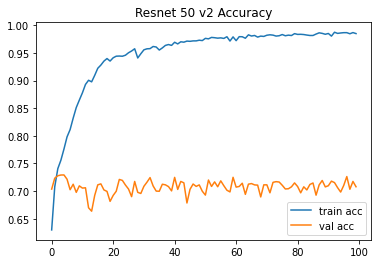

In [21]:
# accuracies
plt.plot(resnet_50_v2_history.history['acc'], label='train acc')
plt.plot(resnet_50_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 50 v2 Accuracy")
plt.legend()
plt.show()

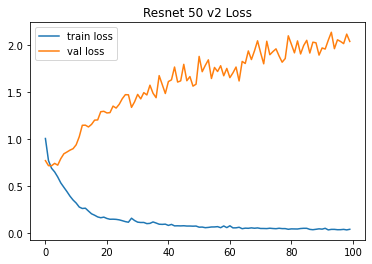

In [22]:
# loss
plt.plot(resnet_50_v2_history.history['loss'], label='train loss')
plt.plot(resnet_50_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 v2 Loss")
plt.legend()
plt.show()

In [23]:
#predict
y_pred=resnet_50_v2_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

235/235 [==============================] - 6s 21ms/step
              precision    recall  f1-score   support

           0       0.60      0.65      0.62       536
           1       0.88      0.76      0.82      4394
           2       0.22      0.43      0.29        72
           3       0.59      0.68      0.63      2305
           4       0.08      0.15      0.11       207

    accuracy                           0.71      7514
   macro avg       0.48      0.53      0.49      7514
weighted avg       0.75      0.71      0.72      7514



In [24]:
print(confusion_matrix(y_pred,y_test))#get confusion matrix

resnet_50_v2_model.save("/content/drive/MyDrive/diabetic_retinopathy_resnet_50v2_model.h5", save_format="h5")

[[ 347   13   18  154    4]
 [  52 3333   12  805  192]
 [  17    3   31   19    2]
 [ 157  353   80 1573  142]
 [   2   70    2  102   31]]
